# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
print(os.chdir('gdrive/My Drive'))
print(os.listdir())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
None
['appdata', 'appdata (1)', 'Facebook Hacks', 'Vashu', 'Kamna car loan', 'Python', 'WhatsApp Video 2018-02-28 at 2.25.22 PM.mp4', 'Fee receipt 3rd year.pdf', 'Classroom', 'iris.csv', 'YuuDrive', 'Cognitive Class PY0101EN Certificate _ Cognitive Class.pdf', 'database.sqlite', 'Colab Notebooks', '0161CSE107 RISHABH MALIK.pdf', 'Reviews.csv', 'Untitled document.gdoc', 'Assignment 3.ipynb', 'KNN Assignment_.pdf', 'KNN Assignment_.ipynb', 'Assignments_AFR_2018

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:19<00:00, 1829.33it/s]


In [24]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
final['CleanedText']=preprocessed_reviews

In [26]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
#Sorting data according to Time in ascending order
total_points=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
total_points_linear = total_points[:100000]
total_points_RBF    = total_points[:40000]

In [29]:
total_points_linear['Score'].value_counts()
total_points_RBF['Score'].value_counts()

1    35595
0     4405
Name: Score, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
names = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text','CleanedText']

X_linear = total_points_linear[names]
y_linear = total_points_linear['Score']
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.3, random_state=0)

X_tr_linear   , X_cv_linear  , y_tr_linear   , y_cv_linear   = train_test_split(X_train_linear , y_train_linear , test_size=0.3 ,random_state=0)

In [0]:
X_RBF = total_points_RBF[names]
y_RBF = total_points_RBF['Score']
X_train_RBF, X_test_RBF, y_train_RBF, y_test_RBF = train_test_split(X_RBF, y_RBF, test_size=0.3, random_state=0)

X_tr_RBF   , X_cv_RBF  , y_tr_RBF   , y_cv_RBF   = train_test_split(X_train_RBF , y_train_RBF , test_size=0.3 ,random_state=0)

# [4] Featurization

## [4.1] BAG OF WORDS_LINEAR

In [0]:
#BoW
count_vect = CountVectorizer(min_df=15) #in scikit-learn
bow = count_vect.fit(X_tr_linear['CleanedText'].values)

bow_train_linear = bow.fit_transform(X_tr_linear['CleanedText'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_cv_linear = bow.transform(X_cv_linear['CleanedText'])
bow_test_linear = bow.transform(X_test_linear['CleanedText'])
print("the type of count vectorizer CV :",type(bow_cv_linear))
print("the shape of out text BOW CV vectorizer ",bow_cv_linear.get_shape())
print("the number of unique words in CV ", bow_cv_linear.get_shape()[1])

some feature names  ['ability', 'able', 'abroad', 'absence', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed', 'absorbs']
the type of count vectorizer CV : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW CV vectorizer  (21000, 6854)
the number of unique words in CV  6854


## BAG OF WORDS_RBF

In [32]:
#BoW
count_vect = CountVectorizer(min_df=10 , max_features=500) #in scikit-learn
bow = count_vect.fit(X_tr_RBF['CleanedText'].values)

bow_train_RBF = bow.fit_transform(X_tr_RBF['CleanedText'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_cv_RBF = bow.transform(X_cv_RBF['CleanedText'])
bow_test_RBF = bow.transform(X_test_RBF['CleanedText'])
print("the type of count vectorizer CV :",type(bow_cv_RBF))
print("the shape of out text BOW CV vectorizer ",bow_cv_RBF.get_shape())
print("the number of unique words in CV ", bow_cv_RBF.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almonds', 'almost', 'along']
the type of count vectorizer CV : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW CV vectorizer  (8400, 500)
the number of unique words in CV  500


## [4.3] TF-IDF_LINEAR

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=15)
tfidf = tf_idf_vect.fit(X_tr_linear['CleanedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

tfidf_train_linear = tfidf.fit_transform(X_tr_linear['CleanedText'])
tfidf_cv_linear    = tfidf.transform(X_cv_linear['CleanedText'])
tfidf_test_linear  = tfidf.transform(X_test_linear['CleanedText'])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able keep', 'able make']


## TF-IDF_RBF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=15 , max_features = 500)
tfidf = tf_idf_vect.fit(X_tr_RBF['CleanedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

tfidf_train_RBF = tfidf.fit_transform(X_tr_RBF['CleanedText'])
tfidf_cv_RBF    = tfidf.transform(X_cv_RBF['CleanedText'])
tfidf_test_RBF  = tfidf.transform(X_test_RBF['CleanedText'])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almonds', 'almost', 'along']


## [4.4] Word2Vec_LINEAR

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train_linear=[]
for sent in X_tr_linear['CleanedText']:
    list_of_sent_train_linear.append(sent.split())

w2v_model_train_linear=Word2Vec(list_of_sent_train_linear,min_count=5,size=50, workers=4)
print(w2v_model_train_linear.wv.most_similar('great'))
print('='*50)
print(w2v_model_train_linear.wv.most_similar('worst'))

[('fantastic', 0.8634001612663269), ('awesome', 0.8538039922714233), ('terrific', 0.8437891602516174), ('good', 0.8364651799201965), ('excellent', 0.8167093396186829), ('wonderful', 0.7578801512718201), ('perfect', 0.7356405258178711), ('decent', 0.7283515930175781), ('amazing', 0.7214449048042297), ('incredible', 0.7180299758911133)]
[('greatest', 0.8359946012496948), ('best', 0.7944284081459045), ('nastiest', 0.7507307529449463), ('tastiest', 0.6667019128799438), ('superior', 0.6621307730674744), ('nicest', 0.6293503642082214), ('coolest', 0.6161305904388428), ('terrible', 0.6112012267112732), ('experienced', 0.601580023765564), ('smoothest', 0.5903010964393616)]


## Word2Vec_RBF

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train_RBF=[]
for sent in X_tr_RBF['CleanedText']:
    list_of_sent_train_RBF.append(sent.split())

w2v_model_train_RBF=Word2Vec(list_of_sent_train_RBF,min_count=5,size=50, workers=4)
print(w2v_model_train_RBF.wv.most_similar('great'))
print('='*50)
print(w2v_model_train_RBF.wv.most_similar('worst'))

[('good', 0.8213914036750793), ('wonderful', 0.8177700638771057), ('amazing', 0.810189425945282), ('excellent', 0.7831727266311646), ('awesome', 0.7737029790878296), ('fantastic', 0.7631964683532715), ('perfect', 0.7414286136627197), ('delicious', 0.7395033836364746), ('terrific', 0.7059617638587952), ('super', 0.6831293702125549)]
[('closest', 0.9080390930175781), ('richest', 0.8951241970062256), ('coolest', 0.8903452754020691), ('experienced', 0.8851081728935242), ('greatest', 0.8835390210151672), ('skeptic', 0.8630152344703674), ('hooked', 0.8559530377388), ('nicest', 0.8528389930725098), ('abandon', 0.8500655889511108), ('wonder', 0.8478879332542419)]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v_linear

In [0]:
sent_vectors_train_linear = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train_linear: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_linear.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train_linear.append(sent_vec)
print(len(sent_vectors_train_linear))
print(len(sent_vectors_train_linear[0]))
sent_vectors_train_linear = np.nan_to_num(sent_vectors_train_linear)

49000
50


In [0]:
i=0
list_of_sent_cv_linear=[]
for sent in X_cv_linear['CleanedText'].values:
    list_of_sent_cv_linear.append(sent.split())
sent_vectors_cv_linear = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv_linear: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_linear.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_cv_linear.append(sent_vec)
print(len(sent_vectors_cv_linear))
print(len(sent_vectors_cv_linear[0]))
sent_vectors_cv_linear = np.nan_to_num(sent_vectors_cv_linear)

21000
50


In [0]:
i=0
list_of_sent_test_linear=[]
for sent in X_test_linear['CleanedText'].values:
    list_of_sent_test_linear.append(sent.split())
sent_vectors_test_linear = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test_linear: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_linear.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test_linear.append(sent_vec)
print(len(sent_vectors_test_linear))
print(len(sent_vectors_test_linear[0]))
sent_vectors_test_linear = np.nan_to_num(sent_vectors_test_linear)

30000
50


#### Avg w2v_RBF

In [35]:
sent_vectors_train_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train_RBF: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train_RBF.append(sent_vec)
print(len(sent_vectors_train_RBF))
print(len(sent_vectors_train_RBF[0]))
sent_vectors_train_RBF = np.nan_to_num(sent_vectors_train_RBF)

19600
50


In [36]:
i=0
list_of_sent_cv_RBF=[]
for sent in X_cv_RBF['CleanedText'].values:
    list_of_sent_cv_RBF.append(sent.split())
sent_vectors_cv_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv_RBF: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_cv_RBF.append(sent_vec)
print(len(sent_vectors_cv_RBF))
print(len(sent_vectors_cv_RBF[0]))
sent_vectors_cv_RBF = np.nan_to_num(sent_vectors_cv_RBF)

8400
50


In [37]:
i=0
list_of_sent_test_RBF=[]
for sent in X_test_RBF['CleanedText'].values:
    list_of_sent_test_RBF.append(sent.split())
sent_vectors_test_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test_RBF: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train_RBF.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test_RBF.append(sent_vec)
print(len(sent_vectors_test_RBF))
print(len(sent_vectors_test_RBF[0]))
sent_vectors_test_RBF = np.nan_to_num(sent_vectors_test_RBF)

12000
50


#### [4.4.1.2] TFIDF weighted W2v_linear

In [0]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 5000)
tfidf = tfidf_vect.fit_transform(X_tr_linear['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [0]:
w2v_words_list_linear = list(w2v_model_train_linear.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_list_linear))
print(type(w2v_words_list_linear))

number of words that occured minimum 5 times  13481
<class 'list'>


In [0]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_train_linear = []
row = 0
for sent in tqdm(X_tr_linear['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_linear and word in features):
            vec = w2v_model_train_linear.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_train_linear.append(sent_vec)
    #row += 1
tfidf_sent_vectors_train_linear = np.array(tfidf_sent_vectors_train_linear)
print(len(tfidf_sent_vectors_train_linear))
#  return tfidf_sent_vectors_train
tfidf_sent_vectors_train_linear = np.nan_to_num(tfidf_sent_vectors_train_linear)

100%|██████████| 49000/49000 [04:34<00:00, 178.57it/s]

49000


In [0]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_cv_linear = []
row = 0
for sent in tqdm(X_cv_linear['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_linear and word in features):
            vec = w2v_model_train_linear.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_cv_linear.append(sent_vec)
    #row += 1
tfidf_sent_vectors_cv_linear = np.array(tfidf_sent_vectors_cv_linear)
print(len(tfidf_sent_vectors_cv_linear))
#  return tfidf_sent_vectors_cv
tfidf_sent_vectors_cv_linear = np.nan_to_num(tfidf_sent_vectors_cv_linear)

100%|██████████| 21000/21000 [01:57<00:00, 178.22it/s]

21000


In [0]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_test_linear = []
row = 0
for sent in tqdm(X_test_linear['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_linear and word in features):
            vec = w2v_model_train_linear.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_test_linear.append(sent_vec)
    #row += 1
tfidf_sent_vectors_test_linear = np.array(tfidf_sent_vectors_test_linear)
print(len(tfidf_sent_vectors_test_linear))
#  return tfidf_sent_vectors_test
tfidf_sent_vectors_test_linear = np.nan_to_num(tfidf_sent_vectors_test_linear)

100%|██████████| 30000/30000 [02:49<00:00, 176.70it/s]


30000


#### TFIDF weighted W2v_RBF

In [0]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500)
tfidf = tfidf_vect.fit_transform(X_tr_RBF['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [39]:
w2v_words_list_RBF = list(w2v_model_train_RBF.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_list_RBF))
print(type(w2v_words_list_RBF))

number of words that occured minimum 5 times  8510
<class 'list'>


In [40]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_train_RBF = []
row = 0
for sent in tqdm(X_tr_RBF['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_RBF and word in features):
            vec = w2v_model_train_RBF.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_train_RBF.append(sent_vec)
    #row += 1
tfidf_sent_vectors_train_RBF = np.array(tfidf_sent_vectors_train_RBF)
print(len(tfidf_sent_vectors_train_RBF))
#  return tfidf_sent_vectors_train
tfidf_sent_vectors_train_RBF = np.nan_to_num(tfidf_sent_vectors_train_RBF)

100%|██████████| 19600/19600 [00:45<00:00, 427.09it/s]

19600


In [41]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_cv_RBF = []
row = 0
for sent in tqdm(X_cv_RBF['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_RBF and word in features):
            vec = w2v_model_train_RBF.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_cv_RBF.append(sent_vec)
    #row += 1
tfidf_sent_vectors_cv_RBF = np.array(tfidf_sent_vectors_cv_RBF)
print(len(tfidf_sent_vectors_cv_RBF))
#  return tfidf_sent_vectors_cv
tfidf_sent_vectors_cv_RBF = np.nan_to_num(tfidf_sent_vectors_cv_RBF)

100%|██████████| 8400/8400 [00:19<00:00, 440.33it/s]

8400


In [42]:
features = tfidf_vect.get_feature_names()
tfidf_sent_vectors_test_RBF = []
row = 0
for sent in tqdm(X_test_RBF['CleanedText']):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words_list_RBF and word in features):
            vec = w2v_model_train_RBF.wv[word]
            #tfidf_value = tfidf[row, features.index(word)]
            tfidf_value = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    #if(tfidf_sum != 0):
    sent_vec /= tfidf_sum
    tfidf_sent_vectors_test_RBF.append(sent_vec)
    #row += 1
tfidf_sent_vectors_test_RBF = np.array(tfidf_sent_vectors_test_RBF)
print(len(tfidf_sent_vectors_test_RBF))
#  return tfidf_sent_vectors_test
tfidf_sent_vectors_test_RBF = np.nan_to_num(tfidf_sent_vectors_test_RBF)

100%|██████████| 12000/12000 [00:28<00:00, 419.07it/s]

12000


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
import math
alpha_values=[pow(10,j) for j in range (-4,4,1)]
print(alpha_values)
alpha_values_log=[(math.log(pow(10,j))) for j in range (-4,4,1)]
print(alpha_values_log)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137]


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] , 'penalty':['l1','l2']}
sgd=SGDClassifier(loss='hinge' , class_weight='balanced')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(bow_train_linear, y_tr_linear)
print(clf.best_estimator_)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


**L2 Reg is best frome the above result , so we will plot the auc results with l2 reg.**

Maximum AUC value is  0.9276288255835683
Best Hyperparameter alpha is : SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


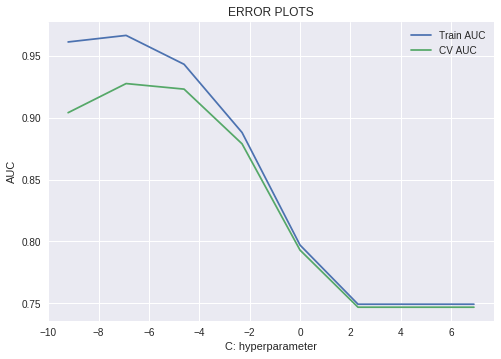

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] }
sgd=SGDClassifier(loss='hinge' , class_weight='balanced' , penalty='l2')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(bow_train_linear, y_tr_linear)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = alpha_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter alpha is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(alpha_values_log , train_auc ,label='Train AUC')
plt.plot(alpha_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  93.50192295721767


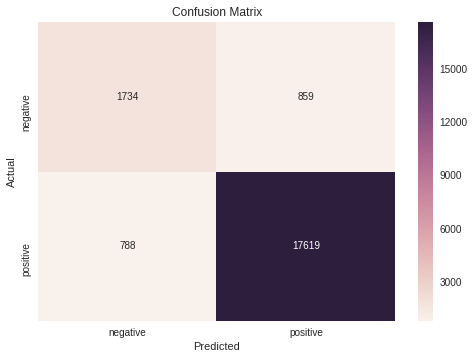

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SGDClassifier(penalty='l2' ,alpha = 0.001, class_weight='balanced' )
clf.fit(bow_train_linear , y_tr_linear )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(bow_train_linear , y_tr_linear)

pred = calib.predict_proba(bow_cv_linear)[:,1]
acc = roc_auc_score(y_cv_linear , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  92.69441716823663


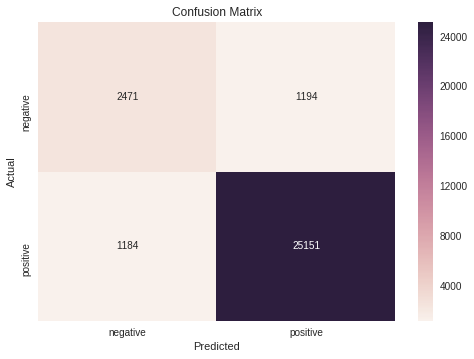

In [0]:
pred = calib.predict_proba(bow_test_linear)[:,1]
acc = roc_auc_score(y_test_linear , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test and Train**

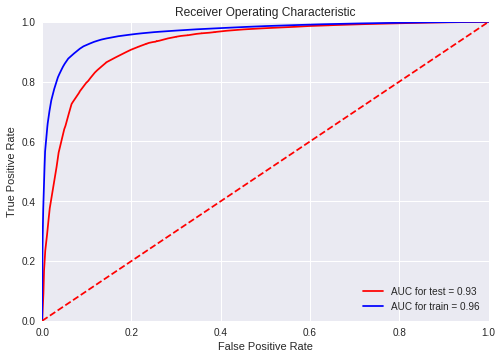

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_linear, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(bow_train_linear)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_linear, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Top 10 positive Features

In [0]:
feat = count_vect.get_feature_names()
coefs = sorted(zip(clf.coef_[0],feat))
for i in coefs[-10:]:
    print(i)

(0.775751025195446, 'pepper')
(0.789756106976397, 'cannot')
(0.8154214202929083, 'experience')
(0.9349831023839379, 'packaged')
(1.0100693961784901, 'trying')
(1.2242146011218291, 'expensive')
(1.3939381067144154, 'corn')
(1.466388706208973, 'fact')
(2.2677709482553987, 'store')
(2.3539714583401343, 'two')


#### Top 10 Negative Features

In [0]:
for i in coefs[:10]:
    print(i)

(-1.3009665645074144, 'nothing')
(-1.0929868540896928, 'home')
(-1.0446873756831068, 'product')
(-0.9078417408447264, 'good')
(-0.7687813060588958, 'people')
(-0.746426351609219, 'gives')
(-0.6858053629726159, 'bit')
(-0.6487532568969915, 'give')
(-0.633576018796299, 'goes')
(-0.6149947635283968, 'cook')


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] , 'penalty':['l1','l2']}
sgd=SGDClassifier(loss='hinge' , class_weight='balanced')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(tfidf_train_linear, y_tr_linear)
print(clf.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


**L2 Reg is best from the above result . Therefore We Will use L2 Reg.**

Maximum AUC value is  0.9547055924867107
Best Hyperparameter alpha is : SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


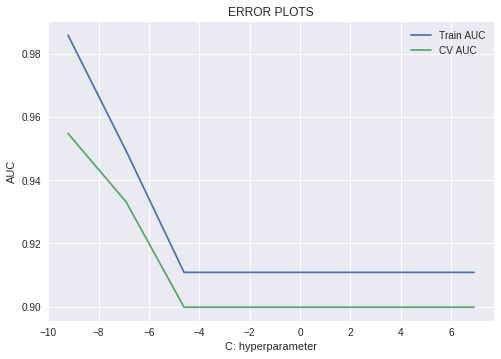

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
#I Compared and l2 is giving best results every time so i am using l2 by default

parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] }
sgd=SGDClassifier(loss='hinge' , class_weight='balanced' , penalty='l2')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(tfidf_train_linear, y_tr_linear)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = alpha_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter alpha is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(alpha_values_log , train_auc ,label='Train AUC')
plt.plot(alpha_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  95.77639343975156


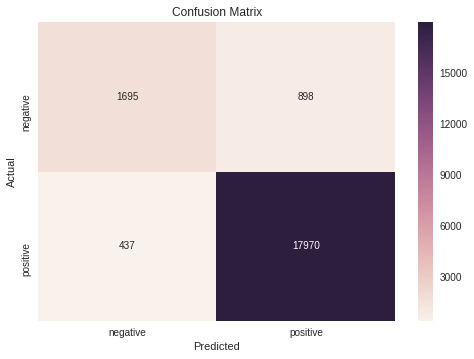

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SGDClassifier(penalty='l2' ,alpha = 0.0001, class_weight='balanced' )
clf.fit(tfidf_train_linear , y_tr_linear )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(tfidf_train_linear , y_tr_linear)

pred = calib.predict_proba(tfidf_cv_linear)[:,1]
acc = roc_auc_score(y_cv_linear , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  95.3709785580946


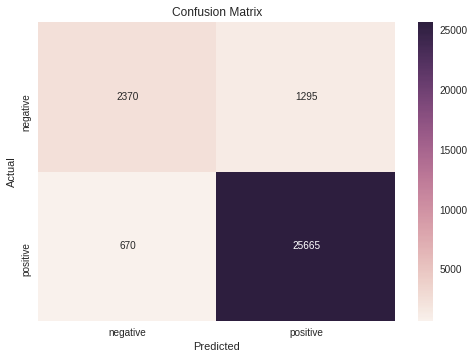

In [0]:
pred = calib.predict_proba(tfidf_test_linear)[:,1]
acc = roc_auc_score(y_test_linear , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test and Train**

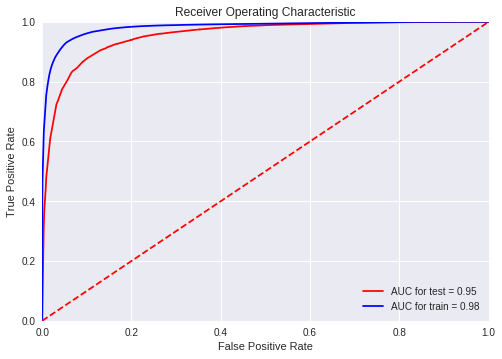

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_linear, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(tfidf_train_linear)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_linear, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Top 10 positive Features

In [0]:
feat = tf_idf_vect.get_feature_names()
coefs = sorted(zip(clf.coef_[0],feat))
for i in coefs[-10:]:
    print(i)

(3.1206235152430124, 'love')
(3.291616255608295, 'wonderful')
(3.3188066946673813, 'excellent')
(3.3225750908812564, 'loves')
(3.3363425712804893, 'perfect')
(3.3545775976904655, 'nice')
(3.533656856747208, 'good')
(4.0535054848067675, 'delicious')
(4.918108885606088, 'best')
(5.939288156459224, 'great')


#### Top 10 Negative Features

In [0]:
for i in coefs[:10]:
    print(i)

(-4.370942927656326, 'not')
(-4.277452432712216, 'disappointed')
(-3.8027142327276318, 'worst')
(-3.42087107208115, 'terrible')
(-3.1703558908996956, 'not worth')
(-2.940411525637612, 'unfortunately')
(-2.929424103006558, 'disappointing')
(-2.889372477810887, 'bland')
(-2.876595373344833, 'not good')
(-2.634252721832445, 'horrible')


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] , 'penalty':['l1','l2']}
sgd=SGDClassifier(loss='hinge' , class_weight='balanced')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(sent_vectors_train_linear, y_tr_linear)
print(clf.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


**L2 Reg is best from the above results and we will use it**

Maximum AUC value is  0.8923698389691987
Best Hyperparameter alpha is : SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


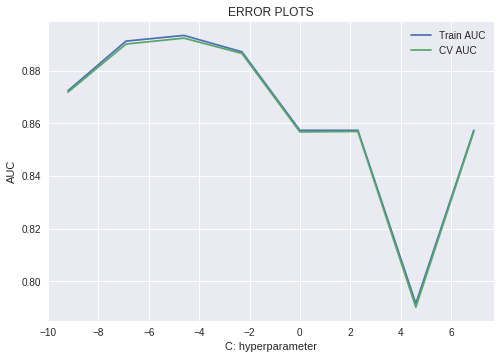

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
#I Compared and l2 is giving best results every time so i am using l2 by default

parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] }
sgd=SGDClassifier(loss='hinge' , class_weight='balanced' , penalty='l2')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(sent_vectors_train_linear, y_tr_linear)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = alpha_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter alpha is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(alpha_values_log , train_auc ,label='Train AUC')
plt.plot(alpha_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  89.37373986082484


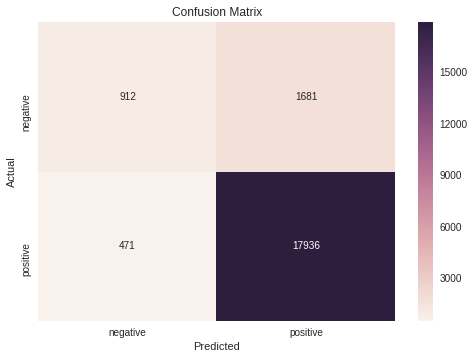

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SGDClassifier(penalty='l2' ,alpha = 0.01, class_weight='balanced' )
clf.fit(sent_vectors_train_linear , y_tr_linear )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(sent_vectors_train_linear , y_tr_linear)

pred = calib.predict_proba(sent_vectors_cv_linear)[:,1]
acc = roc_auc_score(y_cv_linear , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  88.96345776723511


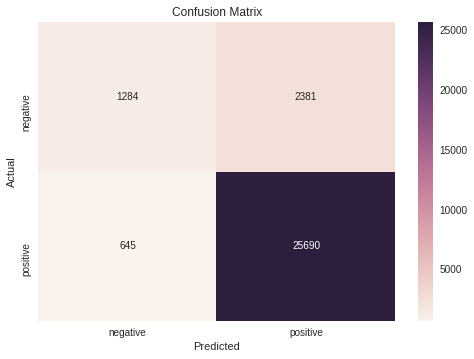

In [0]:
pred = calib.predict_proba(sent_vectors_test_linear)[:,1]
acc = roc_auc_score(y_test_linear , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test and Train**

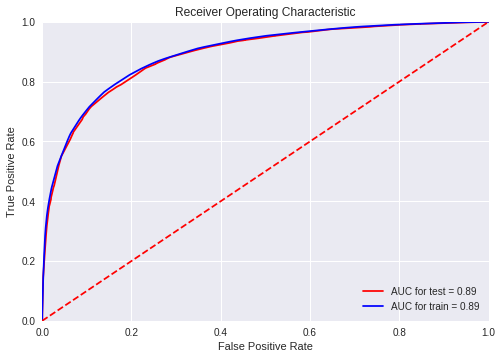

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_linear, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(sent_vectors_train_linear)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_linear, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] , 'penalty':['l1','l2']}
sgd=SGDClassifier(loss='hinge' , class_weight='balanced')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(tfidf_sent_vectors_train_linear, y_tr_linear)
print(clf.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


**L2 Reg is best as we can see from the above Results . Therefore we will use L2 Reg here**

Maximum AUC value is  0.8639591369529054
Best Hyperparameter alpha is : SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


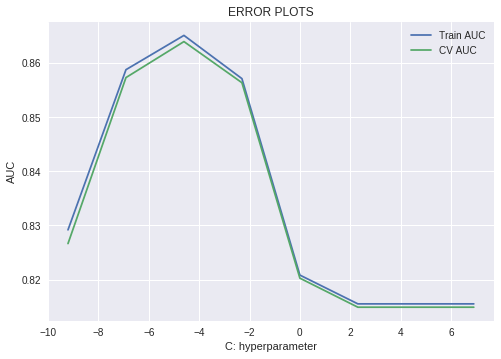

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
#I Compared and l2 is giving best results every time so i am using l2 by default

parameters = {'alpha':[pow(10,j) for j in range (-4,4,1)] }
sgd=SGDClassifier(loss='hinge' , class_weight='balanced' , penalty='l2')

clf=GridSearchCV(sgd , parameters ,cv = 4 , scoring='roc_auc' )
clf.fit(tfidf_sent_vectors_train_linear, y_tr_linear)

train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']


max_y = max(cv_auc)
max_x = alpha_values[cv_auc.argmax()]
print("Maximum AUC value is ",max_y)
print("Best Hyperparameter alpha is :", clf.best_estimator_)

plt.style.use('seaborn')
plt.plot(alpha_values_log , train_auc ,label='Train AUC')
plt.plot(alpha_values_log , cv_auc ,label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  86.35498835925927


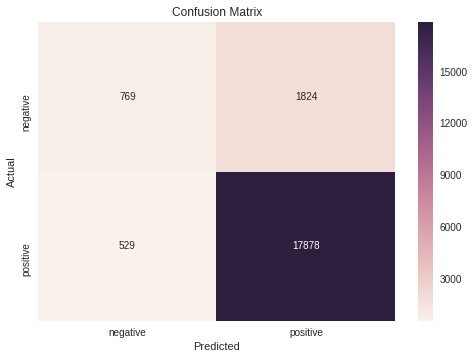

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SGDClassifier(penalty='l2' ,alpha = 0.01, class_weight='balanced' )
clf.fit(tfidf_sent_vectors_train_linear , y_tr_linear )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(tfidf_sent_vectors_train_linear , y_tr_linear)

pred = calib.predict_proba(tfidf_sent_vectors_cv_linear)[:,1]
acc = roc_auc_score(y_cv_linear , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  85.99975962976768


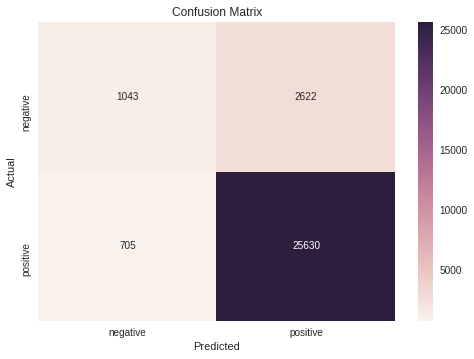

In [0]:
pred = calib.predict_proba(tfidf_sent_vectors_test_linear)[:,1]
acc = roc_auc_score(y_test_linear , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_linear ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test and Train**

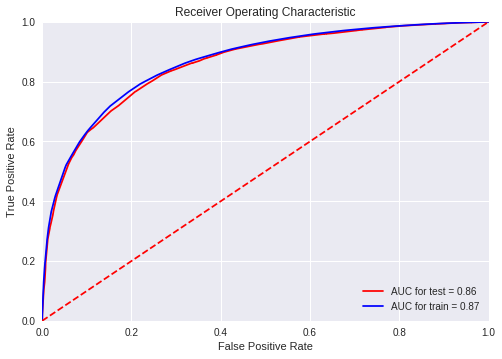

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_linear, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(tfidf_sent_vectors_train_linear)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_linear, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'C':[pow(10,j) for j in range (-4,4,1)] , 'gamma':[0.0001,0.001,0.01,0.1,1,10,100] }
clf=GridSearchCV(SVC( kernel='rbf',class_weight='balanced') ,parameters, scoring='roc_auc', cv=3)

clf.fit(bow_train_RBF, y_tr_RBF)
train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

best_c=clf.best_params_['C']
best_gamma=clf.best_params_['gamma']
print("Best Hyperparameter C is : ", best_c)
print("Best Gamma is : ", best_gamma)

Best Hyperparameter C is :  1
Best Gamma is :  0.01


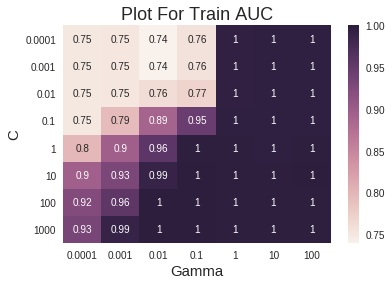

In [0]:
C=[pow(10,j) for j in range (-4,4,1)]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]

scores = np.array(train_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C)
plt.title('Plot For Train AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

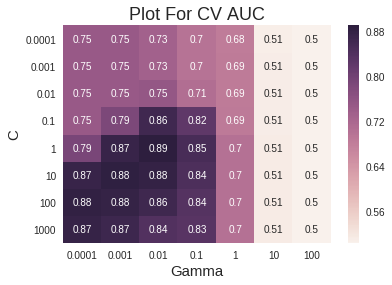

In [0]:
scores = np.array(cv_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C )
plt.title('Plot For CV AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  81.34188949857821


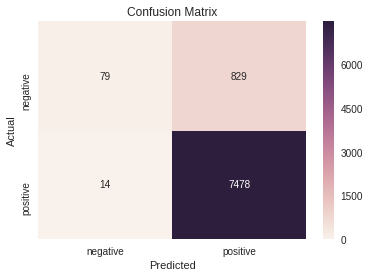

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SVC( C = 1,gamma=0.1, class_weight='balanced' )
clf.fit(bow_train_RBF , y_tr_RBF )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(bow_train_RBF , y_tr_RBF)

pred = calib.predict_proba(bow_cv_RBF)[:,1]
acc = roc_auc_score(y_cv_RBF , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  79.64071040338965


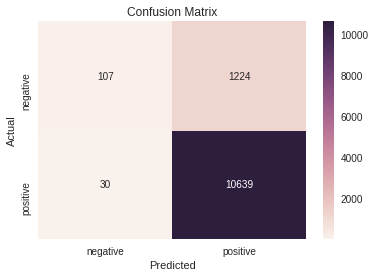

In [0]:
pred = calib.predict_proba(bow_test_RBF)[:,1]
acc = roc_auc_score(y_test_RBF , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test And Train**

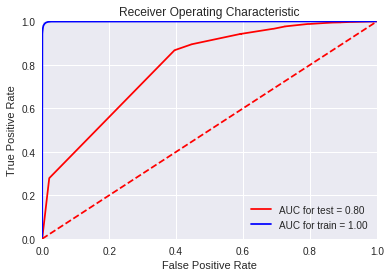

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_RBF, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(bow_train_RBF)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_RBF, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'C':[pow(10,j) for j in range (-4,4,1)] , 'gamma':[0.0001,0.001,0.01,0.1,1,10,100] }
clf=GridSearchCV(SVC( kernel='rbf',class_weight='balanced') ,parameters, scoring='roc_auc', cv=3)

clf.fit(tfidf_train_RBF, y_tr_RBF)
train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

best_c=clf.best_params_['C']
best_gamma=clf.best_params_['gamma']
print("Best Hyperparameter C is : ", best_c)
print("Best Gamma is : ", best_gamma)

Best Hyperparameter C is :  1
Best Gamma is :  1


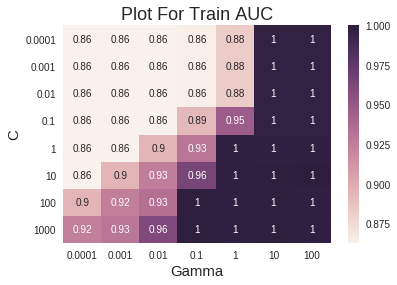

In [0]:
C=[pow(10,j) for j in range (-4,4,1)]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]

scores = np.array(train_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C)
plt.title('Plot For Train AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

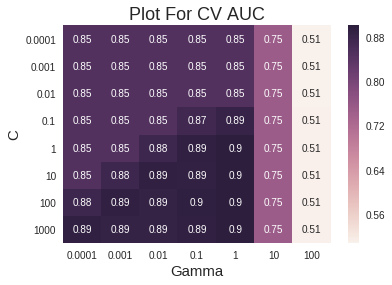

In [0]:
scores = np.array(cv_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C )
plt.title('Plot For CV AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  88.0717478967286


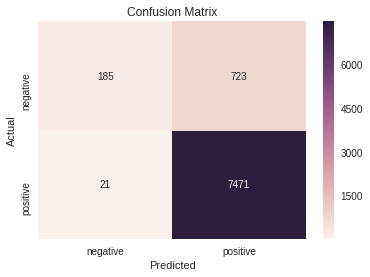

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SVC( C = 1,gamma=1, class_weight='balanced' )
clf.fit(tfidf_train_RBF , y_tr_RBF )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(tfidf_train_RBF , y_tr_RBF)

pred = calib.predict_proba(tfidf_cv_RBF)[:,1]
acc = roc_auc_score(y_cv_RBF , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  86.94920628862249


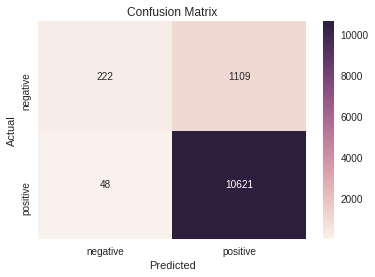

In [0]:
pred = calib.predict_proba(tfidf_test_RBF)[:,1]
acc = roc_auc_score(y_test_RBF , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test And Train**

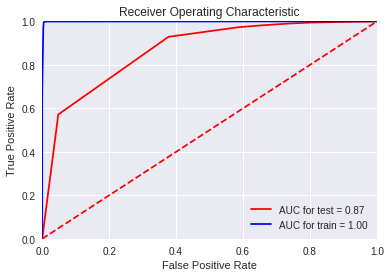

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_RBF, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(tfidf_train_RBF)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_RBF, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'C':[pow(10,j) for j in range (-4,4,1)] , 'gamma':[0.0001,0.001,0.01,0.1,1,10,100] }
clf=GridSearchCV(SVC( kernel='rbf',class_weight='balanced') ,parameters, scoring='roc_auc', cv=3)

clf.fit(sent_vectors_train_RBF, y_tr_RBF)
train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

best_c=clf.best_params_['C']
best_gamma=clf.best_params_['gamma']
print("Best Hyperparameter C is : ", best_c)
print("Best Gamma is : ", best_gamma)

Best Hyperparameter C is :  100
Best Gamma is :  0.01


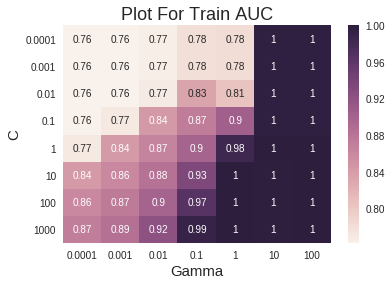

In [0]:
C=[pow(10,j) for j in range (-4,4,1)]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]

scores = np.array(train_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C)
plt.title('Plot For Train AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

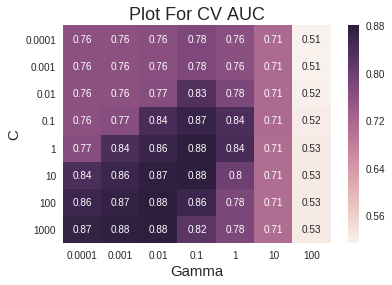

In [0]:
scores = np.array(cv_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C )
plt.title('Plot For CV AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  88.02891954060837


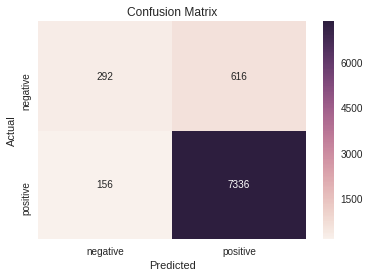

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SVC( C = 100,gamma=0.01, class_weight='balanced' )
clf.fit(sent_vectors_train_RBF , y_tr_RBF )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(sent_vectors_train_RBF , y_tr_RBF)

pred = calib.predict_proba(sent_vectors_cv_RBF)[:,1]
acc = roc_auc_score(y_cv_RBF , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  87.38493577557706


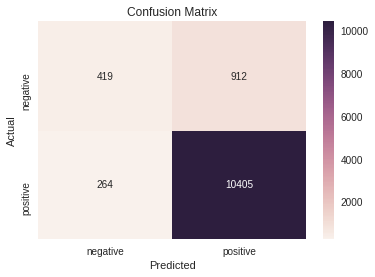

In [0]:
pred = calib.predict_proba(sent_vectors_test_RBF)[:,1]
acc = roc_auc_score(y_test_RBF , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test And Train**

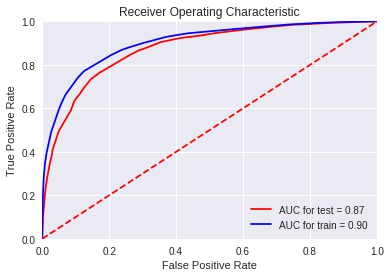

In [0]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_RBF, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(sent_vectors_train_RBF)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_RBF, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'C':[pow(10,j) for j in range (-4,4,1)] , 'gamma':[0.0001,0.001,0.01,0.1,1,10,100] }
clf=GridSearchCV(SVC( kernel='rbf',class_weight='balanced') ,parameters, scoring='roc_auc', cv=3)

clf.fit(sent_vectors_train_RBF, y_tr_RBF)
train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

best_c=clf.best_params_['C']
best_gamma=clf.best_params_['gamma']
print("Best Hyperparameter C is : ", best_c)
print("Best Gamma is : ", best_gamma)

Best Hyperparameter C is :  100
Best Gamma is :  0.01


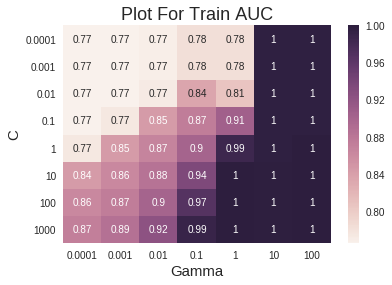

In [44]:
C=[pow(10,j) for j in range (-4,4,1)]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]

scores = np.array(train_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C)
plt.title('Plot For Train AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

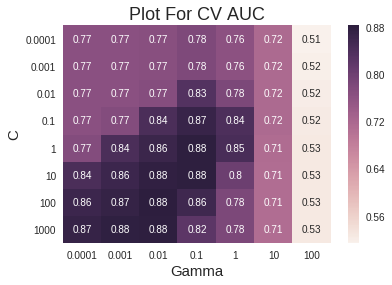

In [45]:
scores = np.array(cv_auc).reshape(8, 7)
sns.heatmap(scores, annot=True, xticklabels=gamma, yticklabels=C )
plt.title('Plot For CV AUC' , fontsize=18)
plt.xlabel('Gamma' , fontsize=15)
plt.ylabel('C' , fontsize=15)
plt.show()

**Checking Accuracy on CV Data**

Accuracy on CV is :  83.96230575462577


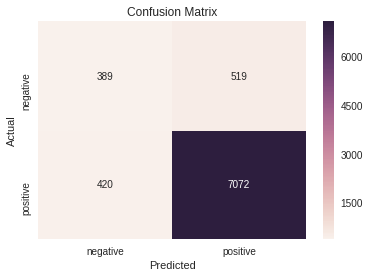

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
clf= SVC( C = 100, gamma=0.01, class_weight='balanced' )
clf.fit(tfidf_sent_vectors_train_RBF , y_tr_RBF )
calib = CalibratedClassifierCV(clf , cv='prefit' ,method='isotonic')
calib.fit(tfidf_sent_vectors_train_RBF , y_tr_RBF)

pred = calib.predict_proba(tfidf_sent_vectors_cv_RBF)[:,1]
acc = roc_auc_score(y_cv_RBF , pred) * 100
print("Accuracy on CV is : ", acc)

y_pred = np.where(pred >0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_cv_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Checking Accuracy on Test Data**

Accuracy on Test is :  83.8560272678894


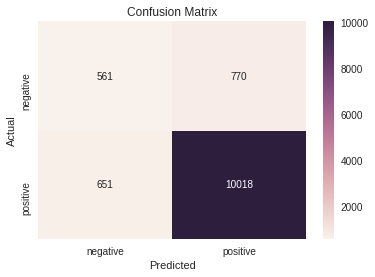

In [47]:
pred = calib.predict_proba(tfidf_sent_vectors_test_RBF)[:,1]
acc = roc_auc_score(y_test_RBF , pred ) * 100
print("Accuracy on Test is : ", acc)

y_pred = np.where( pred>0.5 ,1 ,0)
conf_matrix = confusion_matrix(y_test_RBF ,y_pred)
class_label = ['negative','positive']
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**AUC for Test and Train**

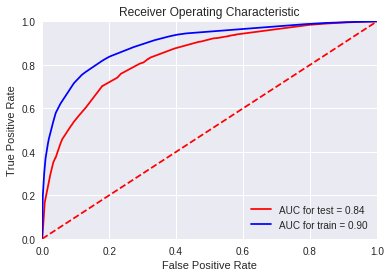

In [48]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test_RBF, pred)
roc_auc = metrics.auc(fpr, tpr)
pred_train= calib.predict_proba(tfidf_sent_vectors_train_RBF)[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_tr_RBF, pred_train)
roc_auc1 = metrics.auc(fpr1, tpr1)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC for test = %0.2f' % roc_auc , color='red' )
plt.plot(fpr1, tpr1, 'b', label = 'AUC for train = %0.2f' % roc_auc1 , color='blue')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [1]:
from prettytable import PrettyTable

x=PrettyTable()
x.field_names=['Vectorizer','','Linear SVM',' ','  ','RBF SVM','   ']
x.add_row(['','HyperParameter C','Accuracy on CV','Accuracy on Test','C|gamma','Accuracy on CV','Accuracy on Test'])
x.add_row(['Bag of Words',0.001,93.50,92.69,'1|0.01',81.34,79.64])
x.add_row(['TF-IDF',0.0001,95.77,95.37,'1|1',88.07,86.94])
x.add_row(['AVG W2V',0.01,89.37,88.96,'100|0.01',88.02,87.38])
x.add_row(['TF-IDF W2V',0.01,86.35,85.99,'100|0.01',83.96,83.85])
print(x)

+--------------+------------------+----------------+------------------+----------+----------------+------------------+
|  Vectorizer  |                  |   Linear SVM   |                  |          |    RBF SVM     |                  |
+--------------+------------------+----------------+------------------+----------+----------------+------------------+
|              | HyperParameter C | Accuracy on CV | Accuracy on Test | C|gamma  | Accuracy on CV | Accuracy on Test |
| Bag of Words |      0.001       |      93.5      |      92.69       |  1|0.01  |     81.34      |      79.64       |
|    TF-IDF    |      0.0001      |     95.77      |      95.37       |   1|1    |     88.07      |      86.94       |
|   AVG W2V    |       0.01       |     89.37      |      88.96       | 100|0.01 |     88.02      |      87.38       |
|  TF-IDF W2V  |       0.01       |     86.35      |      85.99       | 100|0.01 |     83.96      |      83.85       |
+--------------+------------------+-------------

**1. As we can see from above Our Linear SVM with TF-IDF is giving Highest Roc_auc_score**<br>
**2. RBF kernel might perform better with more Data points but due to hardware limitations less points are used**<br>
**3. RBF Kernel Takes more Time**<br>
**4. Linear SVM is faster**